# To what extend are census tracts over- or under-represented in Craigslist rental listings?

For each city, get all rental listings and get count per tract. For each tract that has at least one listing, get census variables (2014 ACS DP) including number of renter-occupied units. Calculate each tract's share of total renter-occupied units. Then allocate the number of listings proportionally according to that share. Then compare how proportional allocation compares to Craigslist allocation.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy import stats
from scipy.stats.mstats import zscore
from shapely.geometry import Point
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

census_data_path = 'data/downloaded_census_data.geojson'
craigslist_path = 'data/listings_joined_tracts.csv'
cities_path = 'data/study_sites.csv'
output_path = 'data/features.csv'

## Load census tracts data

These are all the tracts within our study sites (cities), and they have ACS variables loaded.

In [2]:
tracts = gpd.read_file(census_data_path).rename(columns={'index':'GEOID'}).set_index('GEOID')
assert tracts.index.is_unique
print(len(tracts))
tracts.head(3)

12505


,ALAND,place_geoid,place_name,DP05_0001E,DP05_0017E,DP05_0008PE,DP05_0009PE,DP05_0066PE,DP05_0072PE,DP05_0033PE,...,DP02_0022PE,DP02_0079PE,DP02_0067PE,DP02_0111PE,DP02_0092PE,state,county,DP05_0072PE_2012,DP05_0072PE_2015,geometry
GEOID,,,,,,,,,,,,,,,,,,,,,
01073000100,7549578,0107000,"Birmingham, AL",2970.0,32.2,4.3,16.5,4.6,17.1,78.5,...,3.8,84.7,9.0,94.2,3.1,01,073,15.5,16.9,"POLYGON ((-86.74404800000001 33.573646, -86.74..."
01073000300,2093104,0107000,"Birmingham, AL",2494.0,36.5,7.9,17.2,18.0,4.6,67.2,...,3.6,85.9,14.3,77.7,16.5,01,073,7.6,5.4,"POLYGON ((-86.76195 33.540608, -86.761394 33.5..."
01073000400,8001582,0107000,"Birmingham, AL",3437.0,30.6,7.0,18.1,0.7,7.9,90.8,...,7.3,78.4,3.3,98.2,0.5,01,073,6.9,9.4,"POLYGON ((-86.78617300000001 33.5658, -86.7857..."


## Load listings data

These are cleaned rental listings and they have tracts fips code attached.

In [3]:
%%time
dtypes = {'tract_geoid' : str}
listings = pd.read_csv(craigslist_path, dtype=dtypes)
print(len(listings))

1392866
Wall time: 1.84 s


In [4]:
listings.head()

,date,region,bedrooms,rent,sqft,tract_geoid,lat,lng
0,2014-05-11,santabarbara,3.0,3500.0,1200.0,06083001304,34.399757,-119.726987
1,2014-05-11,santabarbara,2.0,850.0,882.0,06083002924,34.411019,-119.855845
2,2014-05-11,santabarbara,1.0,1290.0,NaN,06083002924,34.410415,-119.854330
3,2014-05-11,santabarbara,1.0,1660.0,NaN,06083000102,34.441460,-119.754324
4,2014-05-11,santabarbara,2.0,3200.0,NaN,06083002924,34.410416,-119.854530


In [5]:
# drop duplicates based on these attributes
listings = listings.drop_duplicates(subset=['rent', 'sqft', 'bedrooms', 'neighborhood'])
len(listings)

392179

In [6]:
# retain only those listings in the census tracts we're interested in, then convert to a geodataframe
mask = listings['tract_geoid'].isin(tracts.index)
listings_in_tracts = gpd.GeoDataFrame(listings[mask])
listings_in_tracts['geometry'] = listings_in_tracts.apply(lambda row: Point((row['lng'], row['lat'])), axis=1)
len(listings_in_tracts)

119005

In [7]:
# add city (place_geoid) to each listing
listings_in_tracts = pd.merge(left=listings_in_tracts, right=tracts[['place_geoid']], 
                              how='inner', left_on='tract_geoid', right_index=True)

In [8]:
# how many tracts are within our cities study areas but have no listings?
tracts_with_listings = listings_in_tracts['tract_geoid'].unique()
pd.Series(tracts.index.isin(tracts_with_listings)).value_counts()

True     8537
False    3968
dtype: int64

The listings are clustered into few tracts. Almost 1/3 of tracts have no listings at all.

In [9]:
# which cities have the most tracts without any craigslist listings?
tracts[~(tracts.index.isin(tracts_with_listings))].groupby(['place_name']).count().iloc[:,0].sort_values(ascending=False).head()

place_name
New York, NY       1316
Chicago, IL         406
Houston, TX         267
Los Angeles, CA     253
Detroit, MI         188
Name: ALAND, dtype: int64

In [10]:
len(tracts)

12505

In [11]:
tracts.columns

Index(['ALAND', 'place_geoid', 'place_name', 'DP05_0001E', 'DP05_0017E',
       'DP05_0008PE', 'DP05_0009PE', 'DP05_0066PE', 'DP05_0072PE',
       'DP05_0033PE', 'DP05_0039PE', 'DP04_0007PE', 'DP04_0088E', 'DP04_0036E',
       'DP04_0025PE', 'DP04_0046PE', 'DP04_0046E', 'DP04_0005E', 'DP04_0048E',
       'DP04_0132E', 'DP04_0139PE', 'DP04_0140PE', 'DP03_0062E', 'DP03_0025E',
       'DP03_0019PE', 'DP03_0128PE', 'DP02_0057PE', 'DP02_0022PE',
       'DP02_0079PE', 'DP02_0067PE', 'DP02_0111PE', 'DP02_0092PE', 'state',
       'county', 'DP05_0072PE_2012', 'DP05_0072PE_2015', 'geometry'],
      dtype='object')

## Calculate distance from each tract's centroid to its city's center.

In [12]:
# load the city names that make up our study sites to get center lat/lng for each
study_sites = pd.read_csv(cities_path, encoding='utf-8')
study_sites['place_name'] = study_sites.apply(lambda row: '{}, {}'.format(row['city'], row['state']), axis=1)
study_sites = study_sites.rename(columns={'lat':'lat_city_center', 'lng':'lng_city_center'}).drop(columns=['city', 'state'])

In [13]:
# merge tracts with cities and calculate each tract's centroid
tracts['centroid'] = tracts.centroid
tracts = pd.merge(tracts.reset_index(), study_sites, how='left', on='place_name')
tracts = tracts.set_index('GEOID')

In [14]:
# calculate distance (km) from each tract's centroid to its city's center
lat1 = tracts['centroid'].map(lambda pt: pt.y)
lng1 = tracts['centroid'].map(lambda pt: pt.x)
lat2 = tracts['lat_city_center']
lng2 = tracts['lng_city_center']
distances_m = ox.great_circle_vec(lat1, lng1, lat2, lng2)
tracts['distance_to_center_km'] = distances_m / 1000.

## Now calculate other features.

In [15]:
# population density (in thousands of persons per km2) and rental unit density (per km2)
tracts['pop_density_k_km'] = (tracts['DP05_0001E'] / 1000.) / (tracts['ALAND'] / 1000000.)
tracts['renter_occupied_units_km'] = tracts['DP04_0046E'] / (tracts['ALAND'] / 1000000.)

In [16]:
# calculate median age and the pct aged 20-34
tracts['pct_20_34'] = tracts['DP05_0008PE'] + tracts['DP05_0009PE']
tracts = tracts.drop(columns=['DP05_0008PE', 'DP05_0009PE'])

In [17]:
# calculate pct of tracts paying more than 30% of income in gross rent
tracts['pct_burden'] = tracts['DP04_0139PE'] + tracts['DP04_0140PE']
tracts = tracts.drop(columns=['DP04_0139PE', 'DP04_0140PE'])

In [18]:
# calculate gross rent, income, and home value in thousands of dollars
tracts['median_gross_rent_k'] = tracts['DP04_0132E'] / 1000.
tracts['med_income_k'] = tracts['DP03_0062E'] / 1000.
tracts['med_home_value_k'] = tracts['DP04_0088E'] / 1000.
tracts = tracts.drop(columns=['DP03_0062E', 'DP04_0088E', 'DP04_0132E'])

In [19]:
# calculate change in pct white over time
tracts['pct_white_change_2012_2015'] = tracts['DP05_0072PE_2015'] - tracts['DP05_0072PE_2012']
tracts = tracts.drop(columns=['DP05_0072PE_2015', 'DP05_0072PE_2012'])

In [20]:
# give every other variable a friendly name
tracts = tracts.rename(columns={'ALAND'      :'land_area',
                                'DP05_0001E' :'total_pop',
                                'DP05_0017E' :'median_age',
                                'DP05_0072PE':'pct_white',
                                'DP05_0066PE':'pct_hispanic',
                                'DP05_0033PE':'pct_black',
                                'DP05_0039PE':'pct_asian',
                                'DP02_0067PE':'pct_bachelors_or_higher',
                                'DP04_0048E' :'renter_household_size',
                                'DP04_0007PE':'pct_single_fam_detached',
                                'DP04_0036E' :'med_rooms_in_house',
                                'DP04_0025PE':'pct_built_before_1940',
                                'DP04_0046PE':'pct_renting',
                                'DP04_0046E' :'count_renter_occupied_units',
                                'DP04_0005E' :'rental_vacancy_rate',
                                'DP03_0025E' :'mean_travel_time_work',
                                'DP03_0019PE':'pct_commute_drive_alone',
                                'DP03_0128PE':'pct_below_poverty',
                                'DP02_0057PE':'pct_college_grad_student',
                                'DP02_0022PE':'pct_nonrelatives_household',
                                'DP02_0079PE':'pct_same_residence_year_ago',
                                'DP02_0111PE':'pct_english_only',
                                'DP02_0092PE':'pct_foreign_born'})
tracts.columns

Index(['land_area', 'place_geoid', 'place_name', 'total_pop', 'median_age',
       'pct_hispanic', 'pct_white', 'pct_black', 'pct_asian',
       'pct_single_fam_detached', 'med_rooms_in_house',
       'pct_built_before_1940', 'pct_renting', 'count_renter_occupied_units',
       'rental_vacancy_rate', 'renter_household_size', 'mean_travel_time_work',
       'pct_commute_drive_alone', 'pct_below_poverty',
       'pct_college_grad_student', 'pct_nonrelatives_household',
       'pct_same_residence_year_ago', 'pct_bachelors_or_higher',
       'pct_english_only', 'pct_foreign_born', 'state', 'county', 'geometry',
       'centroid', 'lat_city_center', 'lng_city_center',
       'distance_to_center_km', 'pop_density_k_km', 'renter_occupied_units_km',
       'pct_20_34', 'pct_burden', 'median_gross_rent_k', 'med_income_k',
       'med_home_value_k', 'pct_white_change_2012_2015'],
      dtype='object')

In [21]:
# turn pcts into proportions
for col in tracts.columns:
    if col.startswith('pct_'):
        tracts[col] = tracts[col] / 100
        tracts = tracts.rename(columns={col:col.replace('pct_', 'prop_')})

In [22]:
# dummies representing if each race is majority in tract
tracts['dummy_white'] = tracts['prop_white'].map(lambda x: 1 if x >= 0.5 else 0)
tracts['dummy_black'] = tracts['prop_black'].map(lambda x: 1 if x >= 0.5 else 0)
tracts['dummy_hispanic'] = tracts['prop_hispanic'].map(lambda x: 1 if x >= 0.5 else 0)
tracts['dummy_asian'] = tracts['prop_asian'].map(lambda x: 1 if x >= 0.5 else 0)

## Allocation of rental units/listings

In each city, allocate all listings proportionately to each tract and count how many craigslist listings actually appear in each tract

In [23]:
# group tracts by cities, so we can loop through one city at a time
# to allocate city's rental listings proportionally among all its tracts
cities_to_tracts = tracts.reset_index().groupby('place_geoid')

In [24]:
proportionate_allocation = pd.Series()
clist_allocation = pd.Series()

# for each city's group of tracts
for city_geoid, group_tracts in cities_to_tracts:
    
    # what share of the city's renter-occupied housing units does each tract have in reality?
    group_tracts = group_tracts.set_index('GEOID')
    tracts_shares = group_tracts['count_renter_occupied_units'] / group_tracts['count_renter_occupied_units'].sum()
    city_listings = listings_in_tracts[listings_in_tracts['place_geoid']==city_geoid]
    
    # allocate rental listings to tracts according to their share of city's renter-occupied units
    prop_allocation_city = tracts_shares * len(city_listings)
    proportionate_allocation = proportionate_allocation.append(prop_allocation_city)
    
    # count how many craigslist listings appear in each tract in this city
    clist_allocation_city = city_listings.groupby('tract_geoid')['place_geoid'].count()
    clist_allocation = clist_allocation.append(clist_allocation_city)
    
# make sure to include any tracts that lack craigslist listings, and give them a zero count
clist_allocation = clist_allocation.reindex(tracts.index, fill_value=0)

# make sure all our counts match up
print(len(tracts))
print(len(clist_allocation))
print(len(proportionate_allocation))
print(len(listings_in_tracts))
print(clist_allocation.sum())
print(int(round(proportionate_allocation.sum())))
assert len(tracts) == len(clist_allocation) == len(proportionate_allocation)
assert len(listings_in_tracts) == clist_allocation.sum() == int(round(proportionate_allocation.sum()))

12505
12505
12505
119005
119005
119005


#### Assemble our dataframe for statistical analysis: first, independent variables from census data

In [25]:
tracts['clist_count'] = clist_allocation
tracts['proportionate_count'] = proportionate_allocation

#### Now calculate and transform dependent variable: how much craigslist is biased, per tract

There are different ways to consider this.

In [26]:
# clean up the dataframe -- remove inf values
to_replace = [np.inf, -np.inf]
tracts = tracts.replace(to_replace, value=np.nan)

# discard any tracts with zero renter-occupied units in them
tracts = tracts[tracts['count_renter_occupied_units'] > 0]

In [27]:
# bias_diff shows how many more listings we have than we would proportionally
tracts['bias_diff'] = tracts['clist_count'] - tracts['proportionate_count']

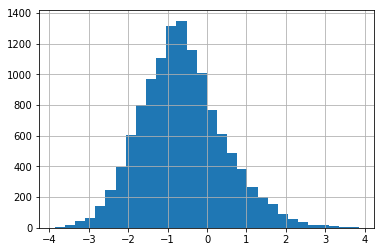

In [28]:
# bias_ratio shows how overrepresented this tract is on craigslist
lmbda = 1
tracts['bias_ratio'] = (tracts['clist_count'] + lmbda) / (tracts['proportionate_count'] + lmbda)
tracts['bias_ratio'] = (tracts['clist_count'] + lmbda) / (tracts['proportionate_count'] + lmbda)

# take log(bias_ratio)
tracts['bias_log'] = np.log(tracts['bias_ratio'])
tracts['bias_log'].hist(bins=30)

Ratios lack symmetry. When a < b, a/b ranges from 0 to 1. When a > b, a/b ranges from 1 to infinity. Log fixes this. When a = b, a/b = 1 and log(a/b) = 0. Because log(a/b) = -log(b/a), it produces symmetry. This is because log(a/b) = log(a)-log(b), so we are evaluating the algebraic different between (log) values, somewhat similar to bias_diff, but sensibly distributed. 

Add lmbda to numerator and denominator to avoid divide by zero and log(0). Without this, the ratios 0/3 and 0/50 would be the same value: 0. In reality, 0/3 suggests that only 3 listings are "missing" whereas 0/50 suggests that 50 are "missing". The latter is much "farther off" the expected value. With lmbda, the ratios instead are 1/4=0.25 and 1/51=0.02. These ratios more accurately reflect how "far off" the craigslist count is from the proportional count. For more info on adding 1 see https://robjhyndman.com/hyndsight/transformations/ or https://discuss.analyticsvidhya.com/t/methods-to-deal-with-zero-values-while-performing-log-transformation-of-variable/2431/4

In [29]:
# or do a box-cox transformation (similar to taking log)
tracts['bias_bc'], lambda_fitted, conf = stats.boxcox(tracts['bias_ratio'], alpha=0.95)

## Determine if tracts are over or under represented

In [30]:
overrepresent_var = 'bias_ratio'
overrepresent_value = 1

In [31]:
# divide data into two subsets: overrepresented vs proportionately/under-represented
mask = tracts[overrepresent_var] > overrepresent_value
over = tracts[mask]
under = tracts[~mask]
print(len(over), len(under))

3078 9250


In [32]:
# make a dummy to indicate if tract is overrepresented
tracts['is_over'] = tracts[overrepresent_var].map(lambda x: 1 if x > overrepresent_value else 0)
tracts['is_over'].value_counts()

0    9250
1    3078
Name: is_over, dtype: int64

## Organize our variables

In [33]:
# get a set of all predictor variables
not_predictors = ['bias_diff', 'bias_ratio', 'bias_log', 'bias_bc', 'centroid', 
                  'clist_count', 'county', 'geometry', 'is_over', 'land_area',
                  'lat_city_center', 'lng_city_center', 'place_geoid', 'place_name', 
                  'proportionate_count', 'state', 'prop_white_change_2012_2015']

predictors_all = tracts.drop(columns=not_predictors).columns

In [34]:
# get all the predictors that are not dummy variables
predictors_no_dummies = [p for p in predictors_all if 'dummy' not in p]

In [35]:
# get a small subset of key variables of interest
predictors_key = ['prop_white', 'renter_household_size', 'prop_below_poverty', 'prop_20_34',
                  'prop_bachelors_or_higher', 'med_income_k', 'median_gross_rent_k']

## Inspect the predictors' relationships with each other

#### and reduce multicollinearity among the predictors

In [36]:
# these predictor vars have the highest pairwise correlations
correlations = tracts[sorted(predictors_no_dummies)].corr()
correlations.stack().abs().sort_values(ascending=False)[len(predictors_no_dummies):].drop_duplicates().head(10)

renter_occupied_units_km  pop_density_k_km            0.935369
prop_foreign_born         prop_english_only           0.868093
med_rooms_in_house        prop_renting                0.816963
prop_english_only         prop_hispanic               0.811745
prop_renting              prop_single_fam_detached    0.753678
med_income_k              prop_below_poverty          0.745893
median_gross_rent_k       med_income_k                0.737837
prop_bachelors_or_higher  med_income_k                0.734205
prop_single_fam_detached  med_rooms_in_house          0.726489
pop_density_k_km          prop_commute_drive_alone    0.722806
dtype: float64

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(correlations, cmap=plt.cm.PiYG_r)
fig.colorbar(cax, fraction=0.045, pad=0.02)
plt.xticks(range(len(correlations.columns)), correlations.columns, rotation=90)
plt.yticks(range(len(correlations.columns)), correlations.columns)
plt.savefig('images/correlation_matrix.jpg', bbox_inches='tight', dpi=300)
plt.close()

In [38]:
# matrix of scatter plots for a subset of explanatory variables
X = tracts[predictors_key]
plots_array = scatter_matrix(X, figsize=(35, 35), alpha=0.2, s=2, diagonal='kde')
plt.savefig('images/scatter_matrix.jpg', bbox_inches='tight', dpi=90)
plt.close()

#### Reduce multicollinearity using predictors' variance inflation factors and design matrix's condition number

A high condition number indicates multicollinearity. Rule of thumb, you want this to be below ~20 (in real-world applied analyses it will often be a bit higher though). Condition number is the ratio of the largest eigenvalue in the design matrix to the smallest. In other words, the large condition number in this case results from scaling rather than from multicollinearity. If we have just one variable with units in the thousands (ie, a large eigenvalue) and add a constant with units of 1 (ie, a small eigenvalue), we'll get a large condition number as the ratio, and statsmodels warns of multicollinearity. If you standardize the design matrix, you'll see condition number without the scaling effects.

VIF is a measure for the collinearity of one variable with all the others. As a rule of thumb, a VIF > 10 indicates strong multicollinearity. If multicollinearity is present in our regression model, the correlated predictors can have large standard errors and thus become insignificant, even though they are theoretically important. By removing redundant predictors, we'll have more sensible regression results for the ones we left in. In statsmodels, the function expects the presence of a constant in the matrix of explanatory variables.

In [39]:
# create design matrix 'X' with no null values, and add constant
X = tracts.dropna()[predictors_all]
Xc = add_constant(X)

In [40]:
# calculate condition number with all predictors and constant (really high)
print(np.linalg.cond(Xc))
print(np.linalg.cond(X))
print(np.linalg.cond(zscore(X)))

397631.3208731783
252959.75673615083
45.94278215830619


In [41]:
# calculate VIF for all predictors and constant (really high) then view top 10
vifs = [vif(Xc.values, i) for i in range(len(Xc.columns))]
pd.Series(data=vifs, index=Xc.columns).sort_values(ascending=False).head(10)

const                       2227.545921
prop_black                   115.341327
prop_white                   109.511528
prop_hispanic                 82.935366
prop_asian                    22.022833
prop_english_only             18.305235
pop_density_k_km              14.120730
renter_occupied_units_km      13.831719
prop_renting                   9.429783
med_income_k                   8.790112
dtype: float64

We have a high condition number and high VIFs, so we should remove redundant or unimportant predictors from model to reduce multicollinearity

In [42]:
# remove some predictors
remove = ['pop_density_k_km', 'renter_occupied_units_km','prop_burden', 
          'count_renter_occupied_units', 'total_pop', 'prop_foreign_born', 
          'prop_renting', 'prop_commute_drive_alone', 'med_home_value_k', 
          'prop_single_fam_detached', 'median_age', 'rental_vacancy_rate',
          'prop_nonrelatives_household', 'prop_below_poverty', 'prop_bachelors_or_higher',
          'dummy_asian', 'dummy_black', 'dummy_hispanic', 'dummy_white',
          'prop_asian', 'prop_black', 'prop_hispanic']

X = tracts.dropna()[predictors_all].drop(columns=remove)
predictors_reduced = sorted(X.columns)
Xc = add_constant(X)
vifs = [vif(Xc.values, i) for i in range(len(Xc.columns))]
pd.Series(data=vifs, index=Xc.columns).sort_values(ascending=False)

const                           243.959781
med_income_k                      4.091008
median_gross_rent_k               3.169320
med_rooms_in_house                3.149822
prop_20_34                        2.925504
prop_college_grad_student         2.587864
renter_household_size             2.563896
prop_white                        2.359638
prop_same_residence_year_ago      2.037508
prop_english_only                 2.000873
mean_travel_time_work             1.983682
distance_to_center_km             1.748052
prop_built_before_1940            1.527182
dtype: float64

In [43]:
# calculate condition number with reduced predictors
print(np.linalg.cond(Xc))
print(np.linalg.cond(X))
print(np.linalg.cond(zscore(X)))

1542.7101970949009
1085.973520782249
5.106415780505718


Due to multicollinearity, we keep white pct, but not the other races. pct_bachelors_or_higher is strongly multicollinear with pct white and med_income, so we have to leave it out as it is redundant.

In [44]:
# now these predictor vars have the highest pairwise correlations
# compare to where we did this earlier: the top 10 are much less correlated now
correlations = X.corr()
correlations.stack().abs().sort_values(ascending=False)[len(X.columns):].drop_duplicates().head(10)

median_gross_rent_k           med_income_k                    0.738751
prop_college_grad_student     prop_20_34                      0.692314
prop_20_34                    prop_same_residence_year_ago    0.593674
med_income_k                  prop_white                      0.572025
med_rooms_in_house            prop_20_34                      0.532764
renter_household_size         prop_college_grad_student       0.470721
prop_college_grad_student     prop_same_residence_year_ago    0.466810
renter_household_size         prop_white                      0.461049
                              prop_english_only               0.435228
prop_same_residence_year_ago  mean_travel_time_work           0.415480
dtype: float64

## Inspect the response variable's relationship with the predictors

In [45]:
response = 'bias_bc'

In [46]:
# bivariate regression, show r^2 and p-value and plot
def bivariate_regress(df, response, predictor, ax):

    # first regress y on x to get slope, intercept, r, p-value, and std error
    x = df[predictor]
    y = df[response]
    m, b, r, p, std_err = stats.linregress(x=x, y=y)
    y_line = m * x + b

    # then scatterplot with bivariate line
    ax.scatter(x, y, s=2, marker='.', zorder=1)
    ax.plot(x, y_line, ls='--', c='k', alpha=0.5, linewidth=1, zorder=2)
    ax.set_xlim((x.min(), x.max()))
    ax.set_ylim((y.min(), y.max()))
    ax.set_xlabel(predictor)
    ax.set_ylabel(response)
    ax.set_title('r2={:.3f}, m={:.3f}, p={:.3f}'.format(r**2, m, p))
    return ax

In [47]:
# create figure and axes
n = len(predictors_reduced)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))
axes = [item for sublist in axes for item in sublist]

# get pairs of dep_var vs ind_var
var_pairs = [(response, predictor) for predictor in predictors_reduced]

# for each axis and pair of variables, plot a simple regression
for ax, (response, predictor) in zip(axes, var_pairs):
    ax = bivariate_regress(tracts.dropna(), response, predictor, ax)

# save to disk and show
fig.savefig('images/scatter_response_vs_predictors_original.jpg', bbox_inches='tight', dpi=150)
plt.close()

#### Transform predictors for better linearity

In [48]:
vars_to_log = ['med_income_k', 'distance_to_center_km', 'mean_travel_time_work', 'renter_household_size']
for var in vars_to_log:
    new_var = '{}_log'.format(var)
    tracts[new_var] = np.log(tracts[var])
    predictors_reduced = [predictor for predictor in predictors_reduced if predictor != var]
    predictors_reduced.append(new_var)

In [49]:
# add any interaction terms
tracts['prop_white*income_log'] = tracts['prop_white'] * tracts['med_income_k_log']
predictors_reduced = sorted(predictors_reduced + ['prop_white*income_log'])

In [50]:
# create figure and axes
n = len(predictors_reduced)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))
axes = [item for sublist in axes for item in sublist]

# get pairs of dep_var vs ind_var
var_pairs = [(response, predictor) for predictor in predictors_reduced]

# for each axis and pair of variables, plot a simple regression
for ax, (response, predictor) in zip(axes, var_pairs):
    ax = bivariate_regress(tracts.dropna(), response, predictor, ax)

# save to disk and show
fig.savefig('images/scatter_response_vs_predictors_transformed.jpg', bbox_inches='tight', dpi=150)
plt.close()

## Remove outliers

In [51]:
threshold = 3 #standard deviations above/below the mean
cols = ['bias_diff', 'bias_log']
outliers = []
for col in cols:
    zscores = (tracts[col] - tracts[col].mean()) / tracts[col].std()
    outlier_tracts = zscores[zscores.abs() > threshold].index
    outliers.extend(outlier_tracts)

len(outliers)
#tracts = tracts.drop(outliers)

266

## Add city dummies to control for regional differences

In [52]:
# add dummies
place_names = sorted(tracts['place_name'].unique())
for place_name in place_names:
    tracts[place_name] = tracts['place_name'].map(lambda x: 1 if x==place_name else 0)

In [53]:
# remove one dummy to prevent perfect collinearity
# ie, a subset of predictors sums to 1 (which full set of dummies will do)
city_dummies = place_names[:-1]
predictors = predictors_reduced + city_dummies

## Show results and save feature set to disk

In [54]:
# done, show results
print(len(tracts))
tracts.head()

12328


,land_area,place_geoid,place_name,total_pop,median_age,prop_hispanic,prop_white,prop_black,prop_asian,prop_single_fam_detached,...,"Salt Lake City, UT","San Antonio, TX","San Diego, CA","San Francisco, CA","San Jose, CA","Seattle, WA","St. Louis, MO","Tampa, FL","Virginia Beach, VA","Washington, DC"
GEOID,,,,,,,,,,,,,,,,,,,,,
01073000100,7549578,0107000,"Birmingham, AL",2970.0,32.2,0.046,0.171,0.785,0.000,0.705,...,0,0,0,0,0,0,0,0,0,0
01073000300,2093104,0107000,"Birmingham, AL",2494.0,36.5,0.180,0.046,0.672,0.084,0.326,...,0,0,0,0,0,0,0,0,0,0
01073000400,8001582,0107000,"Birmingham, AL",3437.0,30.6,0.007,0.079,0.908,0.000,0.897,...,0,0,0,0,0,0,0,0,0,0
01073000500,4819145,0107000,"Birmingham, AL",3735.0,35.8,0.014,0.050,0.929,0.000,0.546,...,0,0,0,0,0,0,0,0,0,0
01073000700,3520564,0107000,"Birmingham, AL",2562.0,25.4,0.025,0.000,0.977,0.000,0.569,...,0,0,0,0,0,0,0,0,0,0


In [55]:
str(predictors_reduced)

"['distance_to_center_km_log', 'mean_travel_time_work_log', 'med_income_k_log', 'med_rooms_in_house', 'median_gross_rent_k', 'prop_20_34', 'prop_built_before_1940', 'prop_college_grad_student', 'prop_english_only', 'prop_same_residence_year_ago', 'prop_white', 'prop_white*income_log', 'renter_household_size_log']"

In [56]:
str(city_dummies)

"['Atlanta, GA', 'Austin, TX', 'Baltimore, MD', 'Birmingham, AL', 'Boston, MA', 'Buffalo, NY', 'Charlotte, NC', 'Chicago, IL', 'Cincinnati, OH', 'Cleveland, OH', 'Columbus, OH', 'Dallas, TX', 'Denver, CO', 'Detroit, MI', 'Hartford, CT', 'Houston, TX', 'Indianapolis, IN', 'Jacksonville, FL', 'Kansas City, MO', 'Las Vegas, NV', 'Los Angeles, CA', 'Louisville, KY', 'Memphis, TN', 'Miami, FL', 'Milwaukee, WI', 'Minneapolis, MN', 'Nashville, TN', 'New Orleans, LA', 'New York, NY', 'Oklahoma City, OK', 'Orlando, FL', 'Philadelphia, PA', 'Phoenix, AZ', 'Pittsburgh, PA', 'Portland, OR', 'Providence, RI', 'Raleigh, NC', 'Richmond, VA', 'Riverside, CA', 'Sacramento, CA', 'Salt Lake City, UT', 'San Antonio, TX', 'San Diego, CA', 'San Francisco, CA', 'San Jose, CA', 'Seattle, WA', 'St. Louis, MO', 'Tampa, FL', 'Virginia Beach, VA']"

In [57]:
tracts.to_csv(output_path, index=True, encoding='utf-8')
print(output_path)

data/features.csv
